#### Build model

In [1]:
%%writefile homerisk_model.py
import pandas as pd
import numpy as np
import re

# modeling
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


MODEL_COLS = [
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
#  'FLAG_MOBIL',
#  'FLAG_EMP_PHONE',
#  'FLAG_WORK_PHONE',
#  'FLAG_CONT_MOBILE',
#  'FLAG_PHONE',
#  'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
    
 'PREV_AMT_DOWN_PAYMENT_sum',
 'PREV_AMT_DOWN_PAYMENT_mean',
 'PREV_SK_ID_PREV_nunique',
 'PREV_RATE_INTEREST_PRIMARY_mean',
 'PREV_AMT_CREDIT_sum',
 'PREV_AMT_CREDIT_mean',
 'PREV_AMT_CREDIT_max',
 'PREV_AMT_CREDIT_min',
 'PREV_AMT_APPLICATION_sum',
 'PREV_AMT_APPLICATION_mean',
 'PREV_AMT_APPLICATION_max',
 'PREV_AMT_APPLICATION_min',
 'PREV_AMT_GOODS_PRICE_sum',
 'PREV_AMT_GOODS_PRICE_mean',
 'PREV_AMT_GOODS_PRICE_max',
 'PREV_AMT_GOODS_PRICE_min',
 'PREV_RATE_INTEREST_PRIVILEGED_mean',
 'prev_pct_down',
 'prev_pct_credit_app',
 'lastloan_NAME_CONTRACT_TYPE',
 'lastloan_AMT_ANNUITY',
 'lastloan_AMT_APPLICATION',
 'lastloan_AMT_CREDIT',
 'lastloan_AMT_DOWN_PAYMENT',
 'lastloan_AMT_GOODS_PRICE',
 'lastloan_WEEKDAY_APPR_PROCESS_START',
 'lastloan_HOUR_APPR_PROCESS_START',
 'lastloan_FLAG_LAST_APPL_PER_CONTRACT',
 'lastloan_NFLAG_LAST_APPL_IN_DAY',
 'lastloan_RATE_DOWN_PAYMENT',
 'lastloan_RATE_INTEREST_PRIMARY',
 'lastloan_RATE_INTEREST_PRIVILEGED',
 'lastloan_NAME_CASH_LOAN_PURPOSE',
 'lastloan_NAME_CONTRACT_STATUS',
 'lastloan_DAYS_DECISION',
 'lastloan_NAME_PAYMENT_TYPE',
 'lastloan_CODE_REJECT_REASON',
 'lastloan_NAME_TYPE_SUITE',
 'lastloan_NAME_CLIENT_TYPE',
 'lastloan_NAME_GOODS_CATEGORY',
 'lastloan_NAME_PORTFOLIO',
 'lastloan_NAME_PRODUCT_TYPE',
 'lastloan_CHANNEL_TYPE',
 'lastloan_SELLERPLACE_AREA',
 'lastloan_NAME_SELLER_INDUSTRY',
 'lastloan_CNT_PAYMENT',
 'lastloan_NAME_YIELD_GROUP',
 'lastloan_PRODUCT_COMBINATION',
 'lastloan_DAYS_FIRST_DRAWING',
 'lastloan_DAYS_FIRST_DUE',
 'lastloan_DAYS_LAST_DUE_1ST_VERSION',
 'lastloan_DAYS_LAST_DUE',
 'lastloan_DAYS_TERMINATION',
 'lastloan_NFLAG_INSURED_ON_APPROVAL',
 'lastloan_PREV_SK_ID_PREV_max',
]
TARGET_COL = 'TARGET'


def prepare_previous_loans(filenm='./previous_application.csv.zip'):
    AGGS = {
        'SK_ID_PREV': ['nunique','max'] ,
        'AMT_APPLICATION':['sum','mean','max','min',] ,
        'AMT_CREDIT':['sum','mean','max','min',] ,
        'AMT_DOWN_PAYMENT':['sum','mean',] ,
        'AMT_GOODS_PRICE':['sum','mean','max','min',] ,
        'RATE_INTEREST_PRIMARY':['mean',] ,
        'RATE_INTEREST_PRIVILEGED':['mean',] ,
    }
    previous = pd.read_csv(filenm)
    prev_aggs = previous.groupby('SK_ID_CURR').agg(AGGS)
    prev_aggs.columns = [ 'PREV_' + '_'.join(col).strip() for col in prev_aggs.columns.values]
    prev_aggs.reset_index(inplace=True)

    # add new calculations 
    prev_aggs['prev_pct_down'] = prev_aggs.PREV_AMT_DOWN_PAYMENT_sum / prev_aggs.PREV_AMT_APPLICATION_sum
    prev_aggs['prev_pct_credit_app'] = prev_aggs.PREV_AMT_CREDIT_sum / prev_aggs.PREV_AMT_APPLICATION_sum
    prev_aggs.replace(np.inf, np.nan, inplace=True)
    
    # get last loan 
    last_loan = pd.merge(previous, prev_aggs[['PREV_SK_ID_PREV_max']], left_on=['SK_ID_PREV'],right_on=['PREV_SK_ID_PREV_max'])
    last_loan.columns = [ 'lastloan_'+c if c not in ['SK_ID_PREV','SK_ID_CURR'] else c for c in last_loan.columns]

    # merge into aggregated dataset
    prevs_w_last = pd.merge(prev_aggs, last_loan, how='left', on=['SK_ID_CURR'], suffixes=('','_lastloan'))
    del prevs_w_last['PREV_SK_ID_PREV_max']
    
    return prevs_w_last


class RiskModel:
    
    
    def __init__(self, 
                 train, 
                 test, 
                 val=pd.DataFrame([]), 
                 params={}, 
                 type='RF', 
                 rounds=0,
                 cols=MODEL_COLS,
                 target=TARGET_COL,
        ):
        ''' Initialize but do nothing
        '''
        self.train = train.copy()
        self.test = test.copy()
        self.val = val.copy()
        self.feature_lookup = {}
        self.feature_lookup_rev = {}
        self.params = params
        self.model = None
        self.type = type
        self.preds = None
        self.rounds = rounds
        self.cols = cols
        self.target = target
    
    
    def build_lookups(self):
        ''' Build encoding lookups
        '''
        val_lookup = {}
        val_lookup_rev = {}
        for i, c in self.train.iteritems():

            if is_string_dtype(c):
                u = np.unique(c.astype('str'))
                kv = { v:i for i, v in zip(np.arange(u.shape[0]),u) }
                vk = { i:v for i, v in zip(np.arange(u.shape[0]),u) }
                val_lookup[i] = kv
                val_lookup_rev[i] = vk
        
        self.feature_lookup = val_lookup
        self.feature_lookup_rev = val_lookup_rev
    
    
    @staticmethod
    def find_encoding(x, lookup):
        
        if x in lookup:
            
            return lookup[x]
        
        else:
            
            return np.nan
    
    
    @staticmethod
    def ohe_cols(ohe, str_columns):
        ohecols = []
        m = ohe.feature_indices_[-1]
        for i, ind in enumerate(ohe.feature_indices_[:-1]):
            col = list(str_columns)[i]
            next_ind = ohe.feature_indices_[i+1]
            newcols = [ col+'_'+str(z) for z in range(next_ind - ind) ]
            ohecols += newcols

        return ohecols
    
    
    def run_encodings(self, ohe=True, minmax=False, pca=False):
        ''' Encode values in training data
        '''
        strings = []
        is_val = self.val.shape[0] >0
        for i, c in self.train.iteritems():
            
            if is_string_dtype(c):
                
                # add list of string columns
                strings.append(i)
                
                # fill nulls with value 'nan' and encode with numeric values
                self.train[i] = self.train[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
                self.test[i] = self.test[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
                
                # check if validation dataset exists and encode if so
                if is_val:
                    
                    self.val[i] = self.val[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
        
        strcols = self.train[strings].columns
        if ohe:
            
            # create one hot encoder & transform data into OHE matrices
            oh = OneHotEncoder( handle_unknown='ignore', sparse=False )
            train_ohe = oh.fit_transform(self.train.loc[:, strings])
            test_ohe = oh.transform(self.test.loc[:, strings].fillna(99999))
            
            # check if validation dataset exists, if so then transform with OHE
            if is_val:
                val_ohe = oh.transform(self.val.loc[:, strings].fillna(99999))
            
            # create names for new OHE matrix columns
            ohecols = self.ohe_cols(oh, strcols)
            
            # add new OHE datasets into dataframes
            train_ohe = pd.DataFrame(train_ohe, columns=[ohecols], index=self.train.index)
            test_ohe = pd.DataFrame(test_ohe, columns=[ohecols], index=self.test.index)
            self.train = pd.concat((self.train, train_ohe), axis=1)
            self.test = pd.concat((self.test, test_ohe), axis=1)
            
            # check if validation dataset exists, if so concatenate results
            if is_val:
                val_ohe = pd.DataFrame(val_ohe, columns=[ohecols], index=self.val.index)
                self.val = pd.concat((self.val, val_ohe), axis=1)
            
            # exclude original columns
            newcols = list(set(self.cols + ohecols))
            self.cols = [ c for c in newcols if c not in strcols ]
        
        if minmax:
            
            # scale between 0 and 1
            mm = MinMaxScaler(feature_range=(0, 1))
            self.train[ self.cols ] = mm.fit_transform(self.train[ self.cols ].fillna(0))
            self.test[ self.cols ] = mm.transform(self.test[ self.cols ].fillna(0))
            
            if is_val:
                self.val[ self.cols ] = mm.transform(self.val[ self.cols ].fillna(0))
        
        if pca:
            
            cumulative_variance = 0.95
            pca_data_train = []
            pca_data_test = []
            
            if is_val:
                pca_data_val = []
            
            remcols = []
            
            for scol in strcols:
                
                # instantiate pca 
                pc = PCA(random_state=22)
                
                # find all string / ohe cols
                scols = [ c for c in self.cols if re.search(scol, c) ]
                
                # remove string / ohe cols later
                remcols += scols
                
                # PCA fit & transforms
                pca_train = pc.fit_transform( self.train[ self.cols ].fillna(np.random.random()) )
                pca_test = pc.transform( self.test[ self.cols ].fillna(np.random.random()) ) 
                
                if is_val:
                    pca_val = pc.transform( self.val[ self.cols ].fillna(np.random.random()) ) 
                
                # find max point to clip off based on cumulative variance ratios
                amax = np.argmax ( np.cumsum( pc.explained_variance_ratio_ ) > cumulative_variance )
                cols = [ '{}_PCA_{}'.format(scol,z) for z in range(amax+1) ]
                
                # create dataframes to concatenate onto training dataset
                pca_train = pd.DataFrame(pca_train[:, :amax+1], columns=cols, index=self.train.index)
                pca_test = pd.DataFrame(pca_test[:, :amax+1], columns=cols, index=self.test.index)
                
                if is_val:
                    pca_val = pd.DataFrame(pca_val[:, :amax+1], columns=cols, index=self.val.index)
                
                pca_data_train.append(pca_train)
                pca_data_test.append(pca_test)
                
                if is_val:
                    pca_data_val.append(pca_val)
            
            # concatentate all data together
            pca_data_train = pd.concat(pca_data_train, axis=1)
            pca_data_test = pd.concat(pca_data_test , axis=1)
            
            self.train = pd.concat((self.train, pca_data_train), axis=1)
            self.test = pd.concat((self.test, pca_data_test), axis=1)
            
            if is_val:
                pca_data_val = pd.concat(pca_data_val , axis=1)
                self.val = pd.concat((self.val, pca_data_val), axis=1)
            
            # set up new column set without exclusion cols
            pcacols = list(pca_data_train.columns)
            self.cols = list(set(self.cols + pcacols))
            self.cols = [ c for c in self.cols if c not in remcols ]
            
    
    def train_model(self):
        ''' Train a randomforest model 
        '''
        if self.type == 'RF':
            
            # instantiate model
            m = RandomForestClassifier(**self.params)
            
            # fit model and save
            m.fit( self.train[ self.cols].fillna(0), self.train[self.target].values )
            self.model = m 
        
        if self.type == 'LR':
            
            lr = LogisticRegression(**self.params)
            lr.fit( self.train[ self.cols].fillna(0), self.train[self.target].values ) 
            self.model = lr
        
        if self.type == 'XGB':
            
            dtrain = xgb.DMatrix(self.train[ self.cols], label=self.train[self.target])
            
            if self.val.shape[0] > 0:
                
                dval = xgb.DMatrix(self.val[ self.cols], label=self.val[self.target])
                evallist  = [(dtrain,'train'), (dval,'eval')]
                gbdt = xgb.train(
                    self.params,
                    dtrain,
                    self.rounds,
                    evallist,
                    early_stopping_rounds = self.rounds // 10 ,
                    verbose_eval = self.rounds // 10 ,
                )
                self.model = gbdt
                
            else:
                
                gbdt = xgb.train(
                    self.params,
                    dtrain,
                    self.rounds,
                )
                self.model = gbdt
    
    
    def output_predictions(self):
        ''' 
        '''
        if self.type == 'RF' or self.type == 'LR':
            
            preds = self.model.predict_proba(self.test[ self.cols].fillna(0))[:, 1]
            return preds
        
        
        if self.type == 'XGB':
            
            dtest = xgb.DMatrix(self.test[ self.cols])
            preds = self.model.predict( dtest )
            return preds
    
    
    def save_predictions(self):
        ''' Dont output, just save (for validation)
        '''
        if self.type == 'RF' or self.type == 'LR':
            
            preds = self.model.predict_proba(self.test[ self.cols].fillna(0))[:, 1]
            self.test_preds = preds
            
            if self.val.shape[0] > 0:
                
                preds = self.model.predict_proba(self.val[ self.cols].fillna(0))[:, 1]
                self.val_preds = preds
                
        
        if self.type == 'XGB':
            
            dtest = xgb.DMatrix(self.test[ self.cols])
            preds = self.model.predict( dtest )
            self.test_preds = preds
            
            if self.val.shape[0] > 0:
                
                dval = xgb.DMatrix(self.val[ self.cols])
                preds = self.model.predict( dval )
                self.val_preds = preds
    
    
    def run(self):
        self.build_lookups()
        self.run_encodings(ohe=True, minmax=True, pca=False)
        self.train_model()
        self.save_predictions()
        
        # create final output df 
        preds_df = pd.DataFrame(self.test_preds, columns=['TARGET'])
        preds_df['SK_ID_CURR'] = self.test.SK_ID_CURR
        self.preds_df = preds_df


Overwriting homerisk_model.py


In [2]:
from homerisk_model import *
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss

train = pd.read_csv('./application_train.csv.zip')
test = pd.read_csv('./application_test.csv.zip')

# add prior loans
priors = prepare_previous_loans()
train = pd.merge(train, priors, on=['SK_ID_CURR'], how='left')
test = pd.merge(test, priors, on=['SK_ID_CURR'], how='left')

rf_params={
    'n_estimators': 350,
    'min_samples_split': 4,
    'n_jobs': 16,
}
xgb_params ={
    'silent': 1 ,
    'booster': 'gbtree' ,
    'objective': 'binary:logistic' ,
    'eval_metric': 'auc' ,
    'nthread': 16 ,
}
lr_params = {
    'C': 0.001, 
    'n_jobs': 16, 
    'solver':'sag',
}
# prepare to show results
results = []
Xtrue = train[TARGET_COL].values


xgb_params['seed'] =             22
xgb_params['max_depth'] =        4
xgb_params['min_child_weight'] = 2
xgb_params['eta'] =              0.03
xgb_params['gamma'] =            0.001
xgb_params['colsample_bytree'] = 0.85
xgb_params['subsample'] =        0.85

xgb_params['alpha'] =            0.01
xgb_params['lambda'] =           0.01


K = 4
kf = KFold(n_splits=K, shuffle=True, random_state=22)
xgval = np.zeros(train.shape[0])
rfval = np.zeros(train.shape[0])
lrval = np.zeros(train.shape[0])
xgtst = np.zeros(test.shape[0])
rftst = np.zeros(test.shape[0])
lrtst = np.zeros(test.shape[0])

for train_index, test_index in kf.split(train):
    
    # set up neg/pos weightings
    nneg = np.sum(train.iloc[train_index, :][TARGET_COL] == 0)
    npos = np.sum(train.iloc[train_index, :][TARGET_COL] == 1)
    weight_dict = {0:1, 1:nneg/npos}
    
    ## XGB
    xgb_params['scale_pos_weight'] = nneg/npos
    xb = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params = xgb_params, 
        type = 'XGB', 
        rounds = 1400 ,
    )
    xb.run()
    xgval[test_index] = xb.val_preds
    xgtst += xb.test_preds / K
    
    ## RF 
    rf_params['class_weight'] = weight_dict
    rf = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params = rf_params, 
        type = 'RF' 
    )
    rf.run()
    rfval[test_index] = rf.val_preds
    rftst += rf.test_preds / K
    
    ## LR
    lr_params['class_weight'] = weight_dict
    lr = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params = lr_params, 
        type = 'LR' 
    )
    lr.run()
    lrval[test_index] = lr.val_preds
    lrtst += lr.test_preds / K

# pd.DataFrame(results, columns=['Model','ROC','LogLoss','Depth','MCW'])

[0]	train-auc:0.699731	eval-auc:0.694044
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 140 rounds.
[140]	train-auc:0.762928	eval-auc:0.745615
[280]	train-auc:0.779498	eval-auc:0.755053
[420]	train-auc:0.789193	eval-auc:0.75868
[560]	train-auc:0.79656	eval-auc:0.760482
[700]	train-auc:0.803339	eval-auc:0.761708
[840]	train-auc:0.809187	eval-auc:0.762265
[980]	train-auc:0.814988	eval-auc:0.762876
[1120]	train-auc:0.820219	eval-auc:0.763219
[1260]	train-auc:0.825147	eval-auc:0.76329
[1399]	train-auc:0.829958	eval-auc:0.763216
Stopping. Best iteration:
[1259]	train-auc:0.825125	eval-auc:0.763304

[0]	train-auc:0.697886	eval-auc:0.695864
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 140 rounds.
[140]	train-auc:0.761311	eval-auc:0.753247
[280]	train-auc:0.778101	eval-auc:0.761683
[420]	train-auc:0.788318	eval-auc:0.764963
[560

#### Stack models

In [3]:
train['xgbval'] = xgval 
train['rfval'] = rfval
train['lrval'] = lrval
test['xgbval'] = xgtst
test['rfval'] = rftst
test['lrval'] = lrtst


results = []
Xtrue = train[TARGET_COL].values
kf = KFold(n_splits=6, shuffle=True)
stackpreds = np.zeros(train.shape[0])
stackpreds_tst = np.zeros(test.shape[0])


models = [('xg',xgval), ('rf',rfval), ('lr',lrval)]
for m, Xpred in models:
    roc = roc_auc_score(Xtrue, Xpred)
    ll = log_loss(Xtrue, Xpred)
    results.append((m, roc, ll))


stack_params ={
    'silent': 1 ,
    'booster': 'gbtree' ,
    'objective': 'binary:logistic' ,
    'eval_metric': 'auc' ,
    'nthread': 16 ,
}
stack_params['seed'] =             22
stack_params['max_depth'] =        3
stack_params['min_child_weight'] = 1
stack_params['eta'] =              0.03
stack_params['gamma'] =            0.0
stack_params['colsample_bytree'] = 0.9
stack_params['subsample'] =        0.9
stack_params['alpha'] =            0.0
stack_params['lambda'] =           0.0
stack_cols = MODEL_COLS + ['xgbval','rfval','lrval']


for train_index, test_index in kf.split(train):
    
    
    mstack = RiskModel( 
        train = train.iloc[train_index], 
        test = test,
        val = train.iloc[test_index],
        params = stack_params, 
        type = 'XGB', 
        rounds = 800 ,
        cols = stack_cols ,
    )
    mstack.run()
    stackpreds[test_index] = mstack.val_preds
    stackpreds_tst += mstack.test_preds / K


roc = roc_auc_score(Xtrue, stackpreds)
ll = log_loss(Xtrue, stackpreds)
results.append(('stack', roc, ll))

[0]	train-auc:0.760517	eval-auc:0.761056
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 80 rounds.
[80]	train-auc:0.767392	eval-auc:0.767734
[160]	train-auc:0.76922	eval-auc:0.768032
[240]	train-auc:0.77122	eval-auc:0.76808
[320]	train-auc:0.773012	eval-auc:0.768189
Stopping. Best iteration:
[284]	train-auc:0.772222	eval-auc:0.768234

[0]	train-auc:0.760646	eval-auc:0.759036
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 80 rounds.
[80]	train-auc:0.768009	eval-auc:0.765143
Stopping. Best iteration:
[50]	train-auc:0.767873	eval-auc:0.765336

[0]	train-auc:0.761555	eval-auc:0.756467
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 80 rounds.
[80]	train-auc:0.768254	eval-auc:0.763459
[160]	train-auc:0.769938	eval-auc:0.764055
[240]	train-auc:0.77

In [4]:
pd.DataFrame(results, columns=['Model','ROC','LogLoss'])

,Model,ROC,LogLoss
0,xg,0.766749,0.532339
1,rf,0.733380,0.256191
2,lr,0.731165,0.595569
3,stack,0.766459,0.243825


#### Prepare output

In [5]:
# create final output df 
preds_df = pd.DataFrame(stackpreds_tst, columns=['TARGET'])
preds_df['SK_ID_CURR'] = test.SK_ID_CURR

#### Analyze predictions

In [6]:
import seaborn as sns
%matplotlib inline

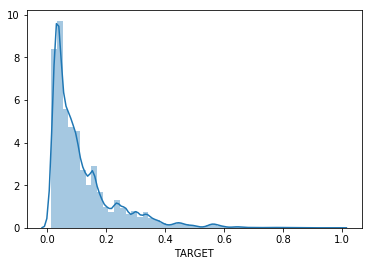

In [7]:
sns.distplot(preds_df.TARGET)

In [8]:
preds_df.loc[preds_df.TARGET > 1, 'TARGET'] = 1

In [9]:
preds_df[['SK_ID_CURR','TARGET']].to_csv('submission.csv', sep=',', header=True, index=False)

In [10]:
!gzip -f submission.csv
!kaggle competitions submit -c home-credit-default-risk -f submission.csv.gz -m "kfold"

Successfully submitted to Home Credit Default Risk